In [1]:
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import os
import umap
import datashader as ds
import colorcet as cc
import igraph
import tqdm
from scipy import sparse
from scipy import stats
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import LatentDirichletAllocation
from statsmodels.stats.multitest import multipletests
from sklearn.cluster import KMeans
from scipy.spatial import Delaunay
import json

from matplotlib.collections import PolyCollection
from matplotlib.colors import ListedColormap

from dredFISH.Analysis import TissueGraph
from dredFISH.Visualization import Viz
from dredFISH.Utils.__init__plots import * 
from dredFISH.Utils import powerplots
from dredFISH.Utils import miscu
from dredFISH.Utils import tmgu

import importlib
importlib.reload(Viz)
importlib.reload(TissueGraph)

<module 'dredFISH.Analysis.TissueGraph' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Analysis/TissueGraph.py'>

#### Load data

In [2]:
respath = '/bigstore/GeneralStorage/fangming/projects/dredfish/figures/'

In [3]:
basepth = '/bigstore/GeneralStorage/Data/dredFISH/Dataset1-t5'
!ls -alhtr $basepth
!head $basepth"/TMG.json"

total 85M
drwxrwxrwx 9 zach     wollmanlab 4.0K Jul 20 10:38 ..
lrwxrwxrwx 1 fangming wollmanlab   67 Jul 20 10:38 DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_matrix.csv -> ../Dataset1-t4/DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_matrix.csv
lrwxrwxrwx 1 fangming wollmanlab   69 Jul 20 10:38 DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_metadata.csv -> ../Dataset1-t4/DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_metadata.csv
-rw-r--r-- 1 fangming wollmanlab   32 Jul 20 10:39 README.txt
-rw-r--r-- 1 fangming wollmanlab   88 Jul 20 10:41 TMG.json
-rw-r--r-- 1 fangming wollmanlab  53M Jul 20 10:41 cell.h5ad
drwxr-xr-x 3 fangming wollmanlab 4.0K Jul 20 10:45 .
-rw-r--r-- 1 fangming wollmanlab  32M Jul 20 10:45 default_analysis.csv
drwxr-xr-x 4 fangming wollmanlab 4.0K Jul 21 11:49 figures
{"layers_graph": [], "layer_taxonomy_mapping": {}, "Taxonomies": [], "Layers": ["cell"]}

In [4]:
df = pd.read_csv(
    os.path.join(basepth, "default_analysis.csv"), index_col=0)
df

,x,y,x2,y2,hemi,b0,b1,b2,b3,b4,...,type_r0.01,type_r0.02,type_r0.05,type_r0.1,type_r0.2,type_r0.5,type_r1,type_r2,type_r5,type_r10
0,1911.666962,-1749.638192,1833.366541,-1831.521636,1,-0.603849,1.714861,0.594060,0.139496,1.509942,...,t1,t1,t1,t3,t2,t4,t3,t16,t47,t40
1,1850.678429,-1747.172043,1772.544083,-1826.392145,1,-0.530279,1.681959,1.301185,-0.464006,1.570054,...,t1,t1,t1,t3,t2,t4,t3,t16,t47,t40
2,1515.123295,-1746.940031,1437.319766,-1811.493848,1,-0.603849,-0.362498,0.620053,-1.128423,1.206578,...,t1,t1,t1,t3,t2,t10,t9,t20,t24,t66
3,1426.161788,-1748.456394,1348.376999,-1809.120415,1,-0.298989,1.023065,1.517082,-0.341796,0.475449,...,t1,t1,t1,t3,t2,t10,t9,t20,t51,t121
4,1739.792930,-1749.407386,1661.666850,-1823.778747,1,-0.603849,-1.351786,1.025515,-1.128423,0.327118,...,t1,t1,t1,t1,t1,t1,t2,t3,t34,t21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77841,-2188.756848,-1084.480934,-2234.065840,-987.777939,0,-0.603849,-0.271399,-0.666686,0.269214,0.821624,...,t1,t1,t1,t3,t2,t8,t18,t36,t56,t57
77842,-2257.822983,-1083.270665,-2303.013073,-983.550072,0,0.936062,0.386319,-0.614982,1.752306,0.067531,...,t1,t1,t3,t4,t6,t8,t10,t6,t1,t73
77843,-2475.320577,-1083.995803,-2520.334508,-974.768090,0,-0.603849,-0.228163,-0.612215,0.895132,0.247026,...,t1,t1,t2,t2,t5,t6,t7,t25,t41,t82
77844,-2311.578984,-1086.717336,-2356.868349,-984.643871,0,-0.603849,-1.153599,0.699586,-0.204732,1.546018,...,t1,t1,t1,t1,t1,t1,t1,t5,t12,t26


In [5]:
TMG = TissueGraph.TissueMultiGraph(basepath=basepth, 
                                   redo=False, # load existing 
                                  )

/bigstore/GeneralStorage/Data/dredFISH/Dataset1-t5/cell.h5ad


In [6]:
# spatial coordinates
layer = TMG.Layers[0]
XY = layer.XY
x, y = XY[:,0], XY[:,1]
###
x, y = y, x # a temporary hack
###

cells = layer.adata.obs.index.values

N = layer.N
# measured basis
ftrs_mat = layer.feature_mat

# umap_mat = umap.UMAP(n_neighbors=30, min_dist=0.1).fit_transform(ftrs_mat)



# Cell-cell interaction
- line (counts; distance)
- triangle (counts; distance)
- local envv (clustering)

In [7]:
def symmetrize(X, indices=None):
    """
    Test case:
        a = np.ones((3,3))
        symmetrize(a)
    """
    X = np.asarray(X)
    m, n = X.shape
    assert m == n
    
    Y = X + X.T
    i, j = np.diag_indices(m)
    Y[i,j] = Y[i,j]/2
    
    if indices is not None:
        Y = pd.DataFrame(Y, index=indices, columns=indices)
    return Y

def count_edgetype(edges, node_types, typeorder=None):
    """
    """
    EL = np.asarray(edges)
    assert EL.shape[1] == 2
    types = node_types
    
    # count edges by types
    countmat = pd.DataFrame(types[EL]).groupby([0,1]).size().unstack().fillna(0).astype(int)
    # symmetrize it
    countmat = symmetrize(countmat, indices=countmat.index.values)
    if typeorder is not None:
        # reordering
        countmat = countmat.reindex(typeorder)[typeorder] # reordering
    
    # make sure the math is correct
    assert np.triu(countmat).sum() == len(EL)
    return countmat

def squareform_with_diag(vec, n_t):
    """
    """
    assert n_t*(n_t+1)/2 == len(vec)
    mat = np.zeros((n_t, n_t))
    mat[np.triu_indices(n_t)] = vec
    mat = symmetrize(mat)
    return mat

def test_edge_enrichment(edges, node_types, typeorder=None, n_repeat=100, random_state=0):
    """
    """
    # house keeping
    EL = np.asarray(edges)
    assert EL.shape[1] == 2
    types = node_types
    np.random.seed(random_state)
    
    # basic stats
    unq_types = np.unique(types)
    n_t = len(unq_types)
    n = len(types)
    
    # counts and shuffled conuts
    countmats = np.zeros((n_t, n_t, n_repeat+1))
    countmat = count_edgetype(EL, 
                              types, # shuffle
                              typeorder=typeorder)
    countmats[:,:,0] = countmat.values
    for i in range(1, n_repeat+1):
        countmat_shuff = count_edgetype(EL, 
                                        types[np.random.choice(n, size=n, replace=False)], # shuffle
                                        typeorder=typeorder)
        countmats[:,:,i] = countmat_shuff.values
        
    # count ~ [1, n_rep+1]; percentiles ~ [0,1]
    prctls = (stats.rankdata(countmats, axis=2)[:,:,0]-1)/n_repeat
    pvals = 2*np.clip(np.minimum(prctls, 1-prctls), 1/n_repeat, None)
    rej, qvals, _, _ = multipletests(pvals[np.triu_indices(n_t)], # indep tests
                                     method='fdr_bh')
    print(qvals.shape, n_t)
    qvals = squareform_with_diag(qvals, n_t)
    enr = (countmat+1)/(np.mean(countmats[:,:,1:], axis=2)+1)
    return countmat, pvals, qvals, enr, countmats

# alpha = 5
# cmat_lo = np.percentile(countmat_shuffs, alpha/2, axis=2)
# cmat_hi = np.percentile(countmat_shuffs, 100-alpha/2, axis=2)
# np.logical_or(countmat < cmat_lo, countmat > cmat_hi)

In [8]:
N = len(XY)

# types
typecol = 'ktype_L3'
types = df[typecol].values

# from meta
f = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/analysis_meta_Mar31.json'
with open(f, 'r') as fh:
    meta = json.load(fh)
typeorder = meta['l3_clsts']

In [9]:
%%time
# edgelist
# layer.SG.simplify() # precaution

EL = np.asarray(layer.SG.get_edgelist())

# types = df['type_r0.1'].values
# typeorder = np.sort(np.unique(types))

types = df['ktype_L3'].values
typeorder = meta['l3_clsts']

countmat, pvals, qvals, enr, countmats = test_edge_enrichment(EL, types, typeorder=typeorder, n_repeat=1000, random_state=0)

(903,) 42
CPU times: user 42.6 s, sys: 60.2 ms, total: 42.7 s
Wall time: 42.7 s


In [10]:
countmat_exp = np.mean(countmats[:,:,1:], axis=2)

In [11]:
# fig, axs = plt.subplots(1,11,figsize=(11*3,1*3))
# for i in range(11):
#     # sns.heatmap(np.log10(countmats[:,:,i]+1), 
#     sns.heatmap(countmats[:,:,i], 
#                 ax=axs[i], 
#                 xticklabels=False, 
#                 yticklabels=False, 
#                 cmap='coolwarm',
#                 cbar=False,)

# countmats[:,:,1], countmats[:,:,2], countmats[:,:,3], countmats[:,:,4]
# np.min(pvals), np.min(qvals)

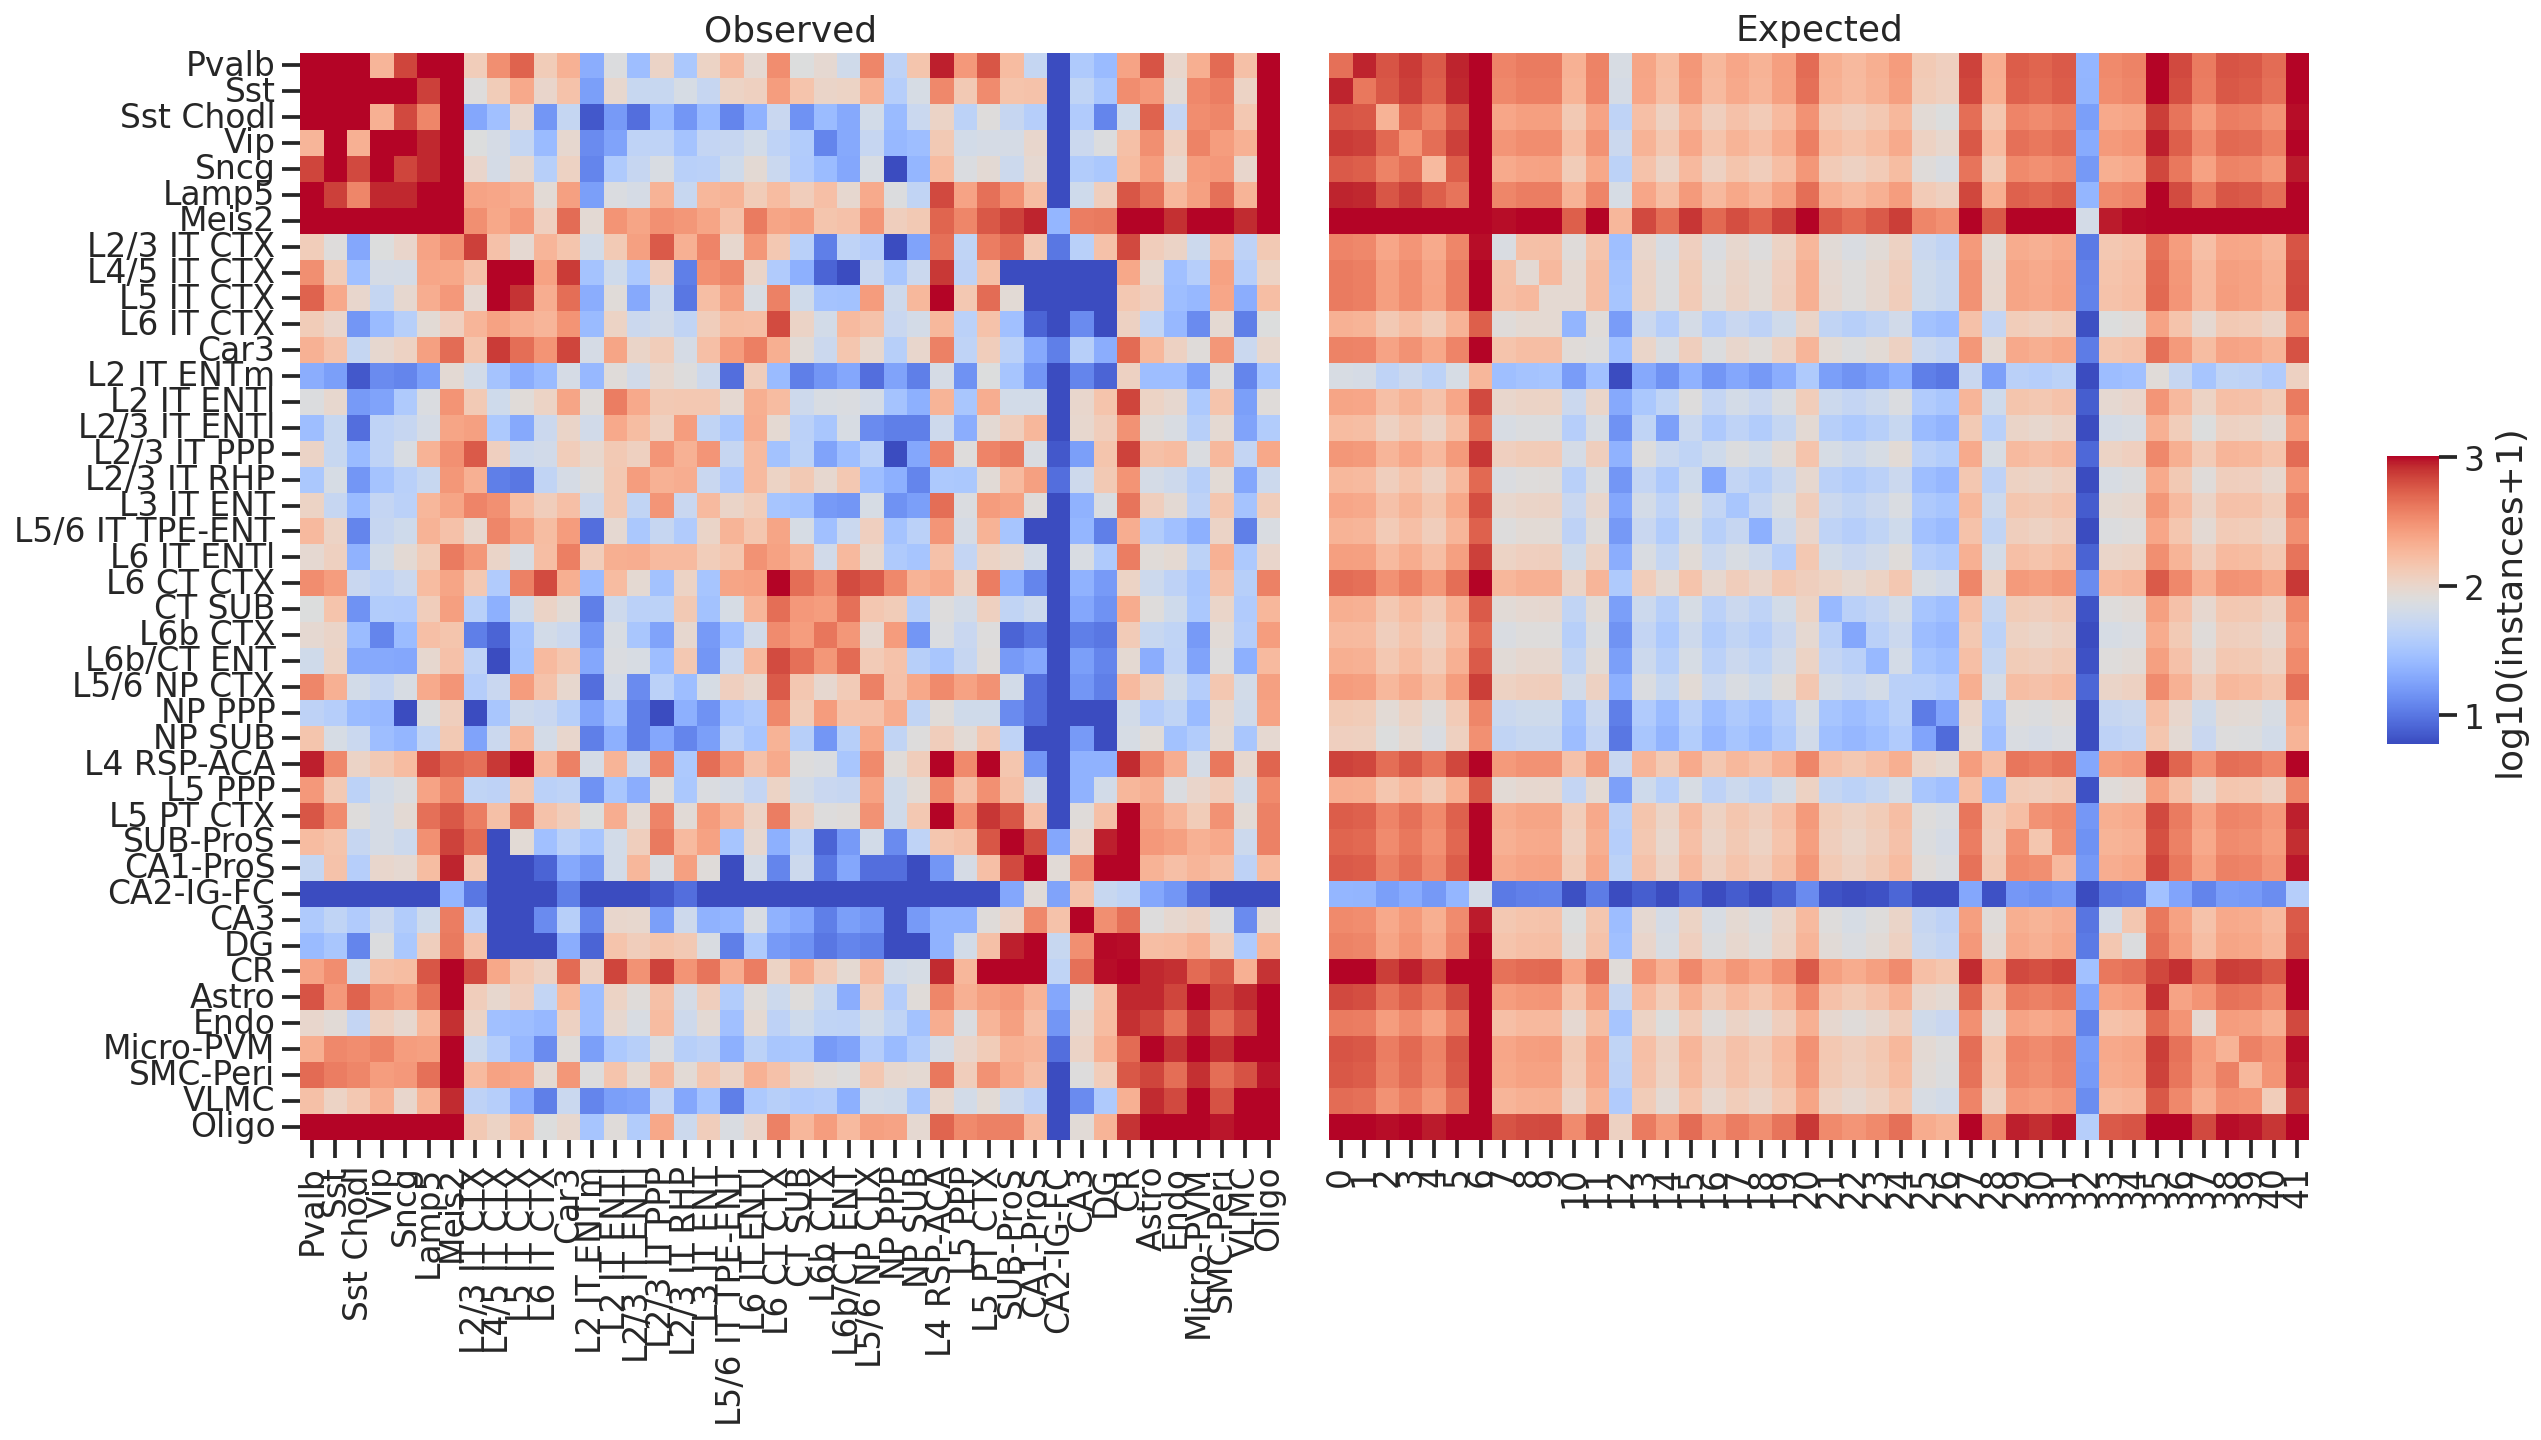

In [12]:
# instances
fig, axs = plt.subplots(1, 2, figsize=(9*2,10))
ax = axs[0]
ax.set_title('Observed')
val = np.log10(countmat+1)
vmax = np.percentile(val, 95)
vmin = np.percentile(val, 5)
cbar_ax = fig.add_axes([0.93, 0.4, 0.02, 0.2])
sns.heatmap(val, 
            xticklabels=True,
            yticklabels=True,
            cmap='coolwarm', 
            vmax=vmax,
            vmin=vmin,
            ax=ax,
            cbar_ax=cbar_ax,
            cbar_kws=dict(shrink=0.5, label='log10(instances+1)')
           )

ax = axs[1]
ax.set_title('Expected')
val = np.log10(countmat_exp+1)
sns.heatmap(val, 
            xticklabels=True,
            yticklabels=False,
            cmap='coolwarm', 
            vmax=vmax,
            vmin=vmin,
            ax=ax,
            cbar_ax=cbar_ax,
            cbar_kws=dict(shrink=0.5, label='log10(instances+1)')
           )
fig.subplots_adjust(wspace=0.05)
plt.show()


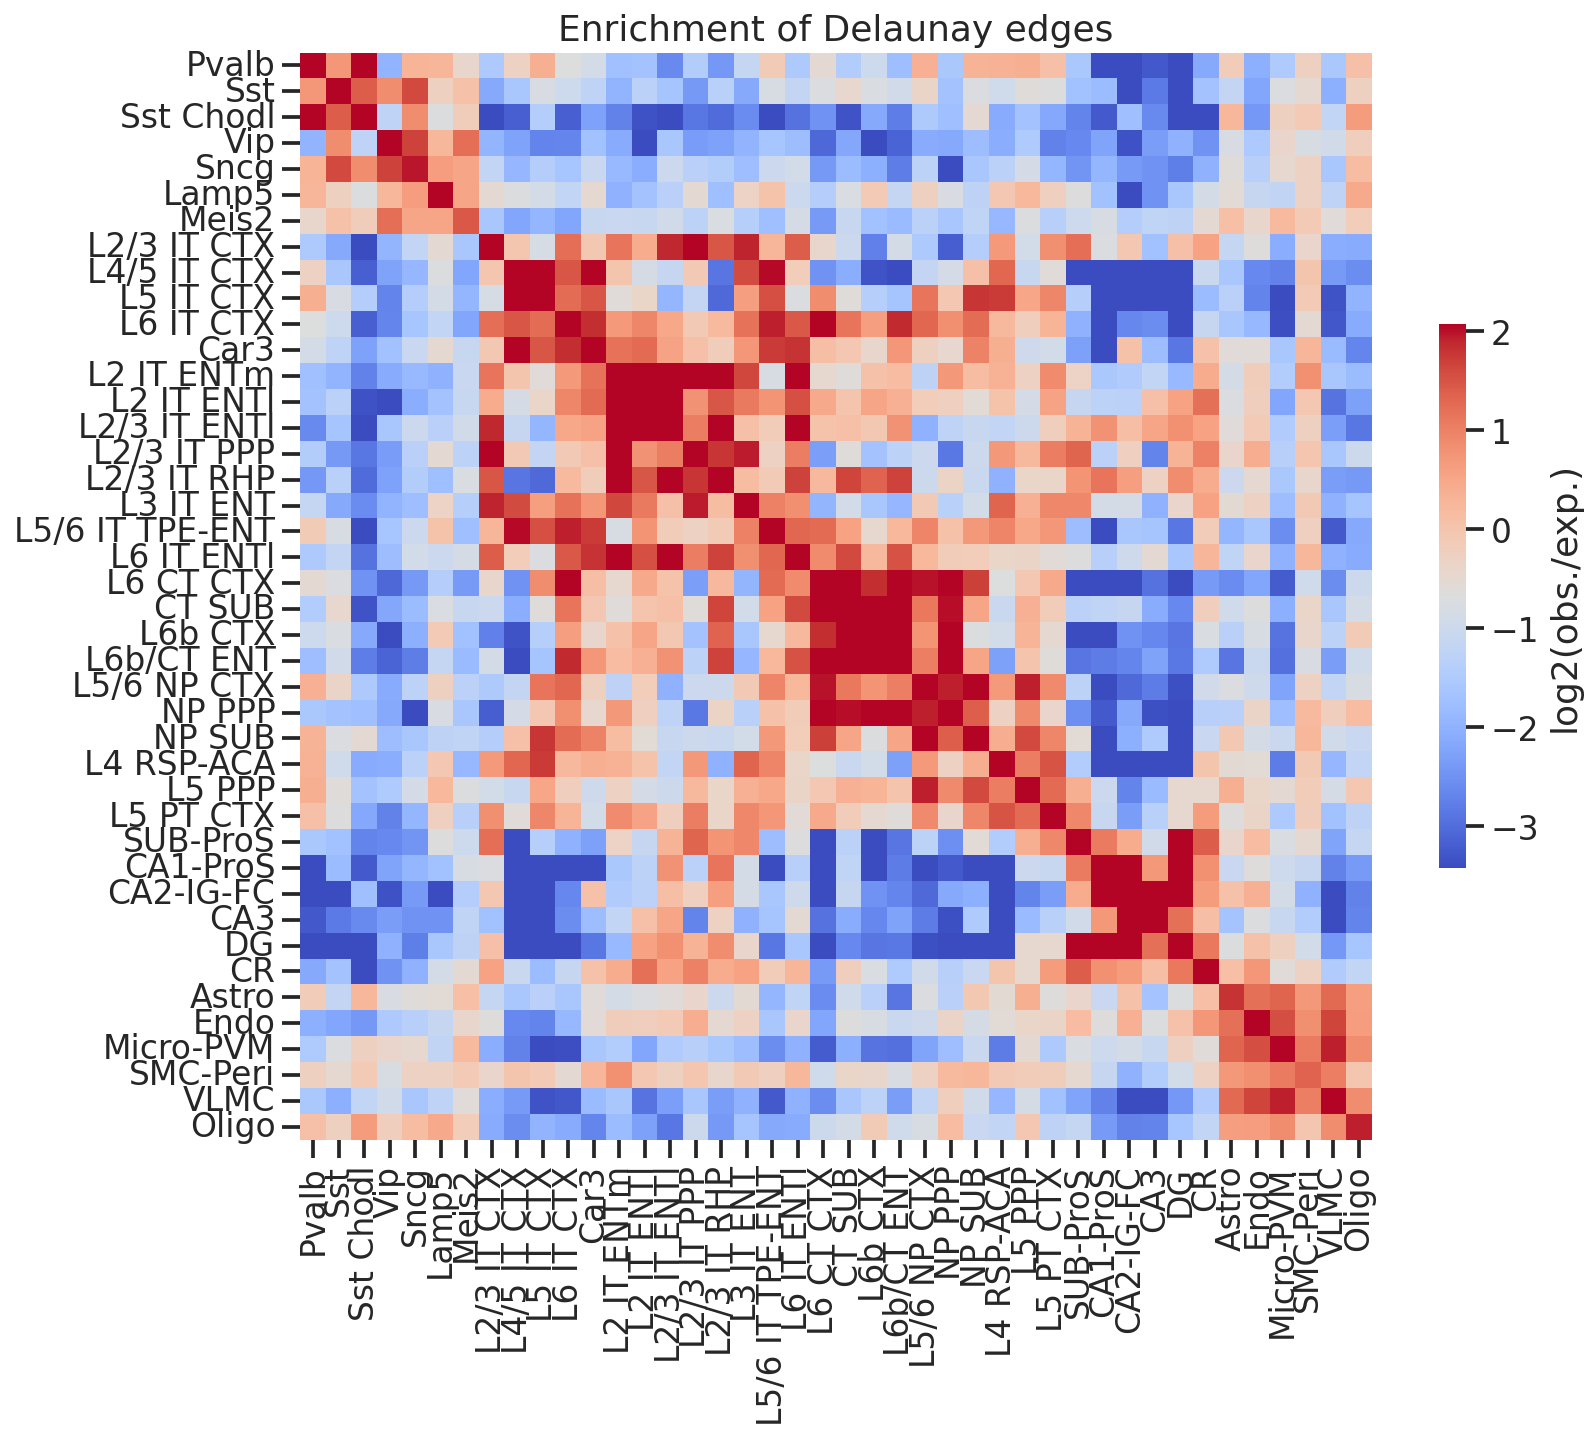

In [13]:
val = np.log2(enr)
fig, ax = plt.subplots(figsize=(12,10))
vmax = np.percentile(val, 95)
vmin = np.percentile(val, 5)
sns.heatmap(val, 
            xticklabels=True,
            yticklabels=True,
            cmap='coolwarm', 
            vmax=vmax,
            vmin=vmin,
            ax=ax,
            cbar_kws=dict(shrink=0.5, label='log2(obs./exp.)')
           )
ax.set_title('Enrichment of Delaunay edges')
plt.show()

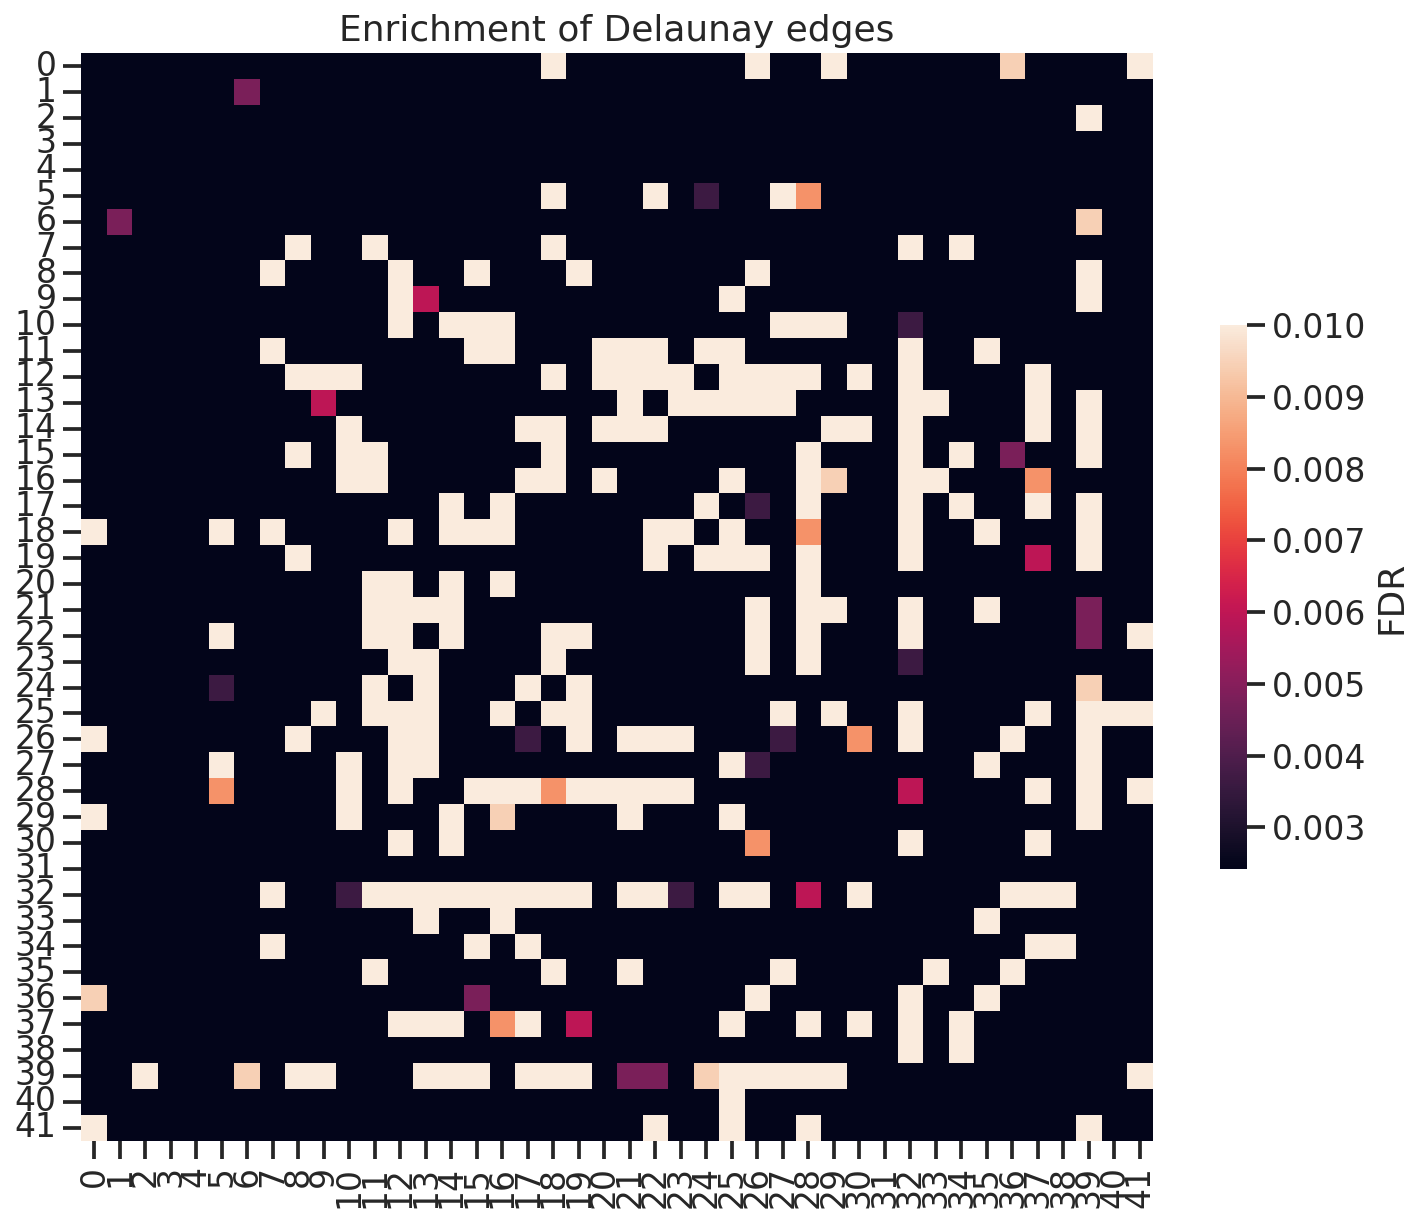

In [14]:
val = qvals
alpha = 0.01
fig, ax = plt.subplots(figsize=(12,10))
# vmax = np.percentile(val, 95)
# vmin = np.percentile(val, 5)
sns.heatmap(val, 
            xticklabels=True,
            yticklabels=True,
            cmap='rocket', 
            # vmax=vmax,
            # vmin=vmin,
            # center=alpha,
            vmax=alpha,
            # center=alpha,
            ax=ax,
            cbar_kws=dict(shrink=0.5, label='FDR')
           )
ax.set_title('Enrichment of Delaunay edges')
plt.show()

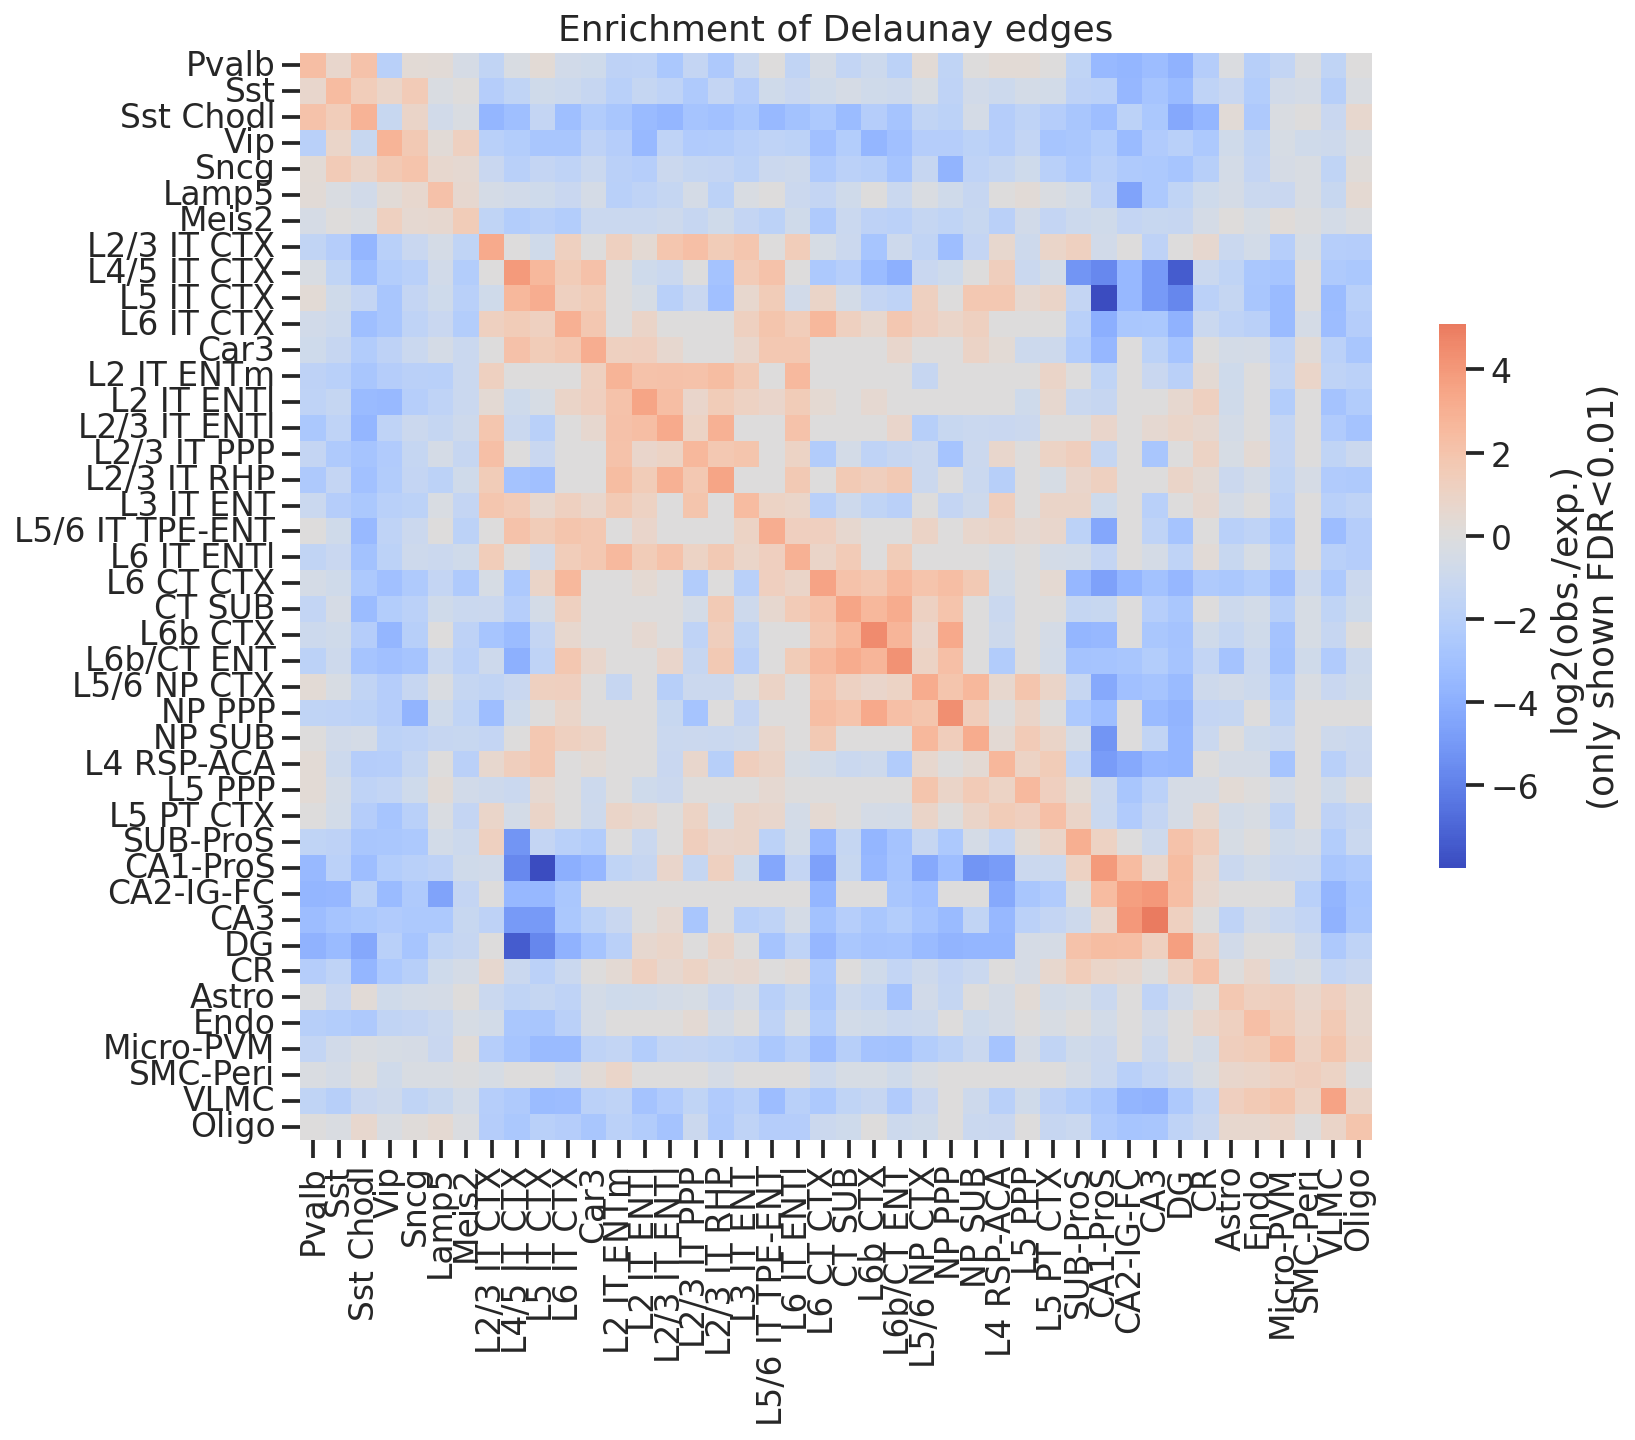

In [15]:
val = np.log2(enr)
val[qvals > alpha] = 0 # insignfiicant

fig, ax = plt.subplots(figsize=(12,10))
vmax = np.percentile(val, 100)
vmin = np.percentile(val, 0)
# vlim = max(vmax, -vmin)
sns.heatmap(val, 
            xticklabels=True,
            yticklabels=True,
            cmap='coolwarm', 
            vmax=vmax, #vlim,
            vmin=vmin, #-vlim,
            center=0,
            ax=ax,
            cbar_kws=dict(shrink=0.5, label='log2(obs./exp.)\n(only shown FDR<0.01)')
           )
ax.set_title('Enrichment of Delaunay edges')
plt.show()

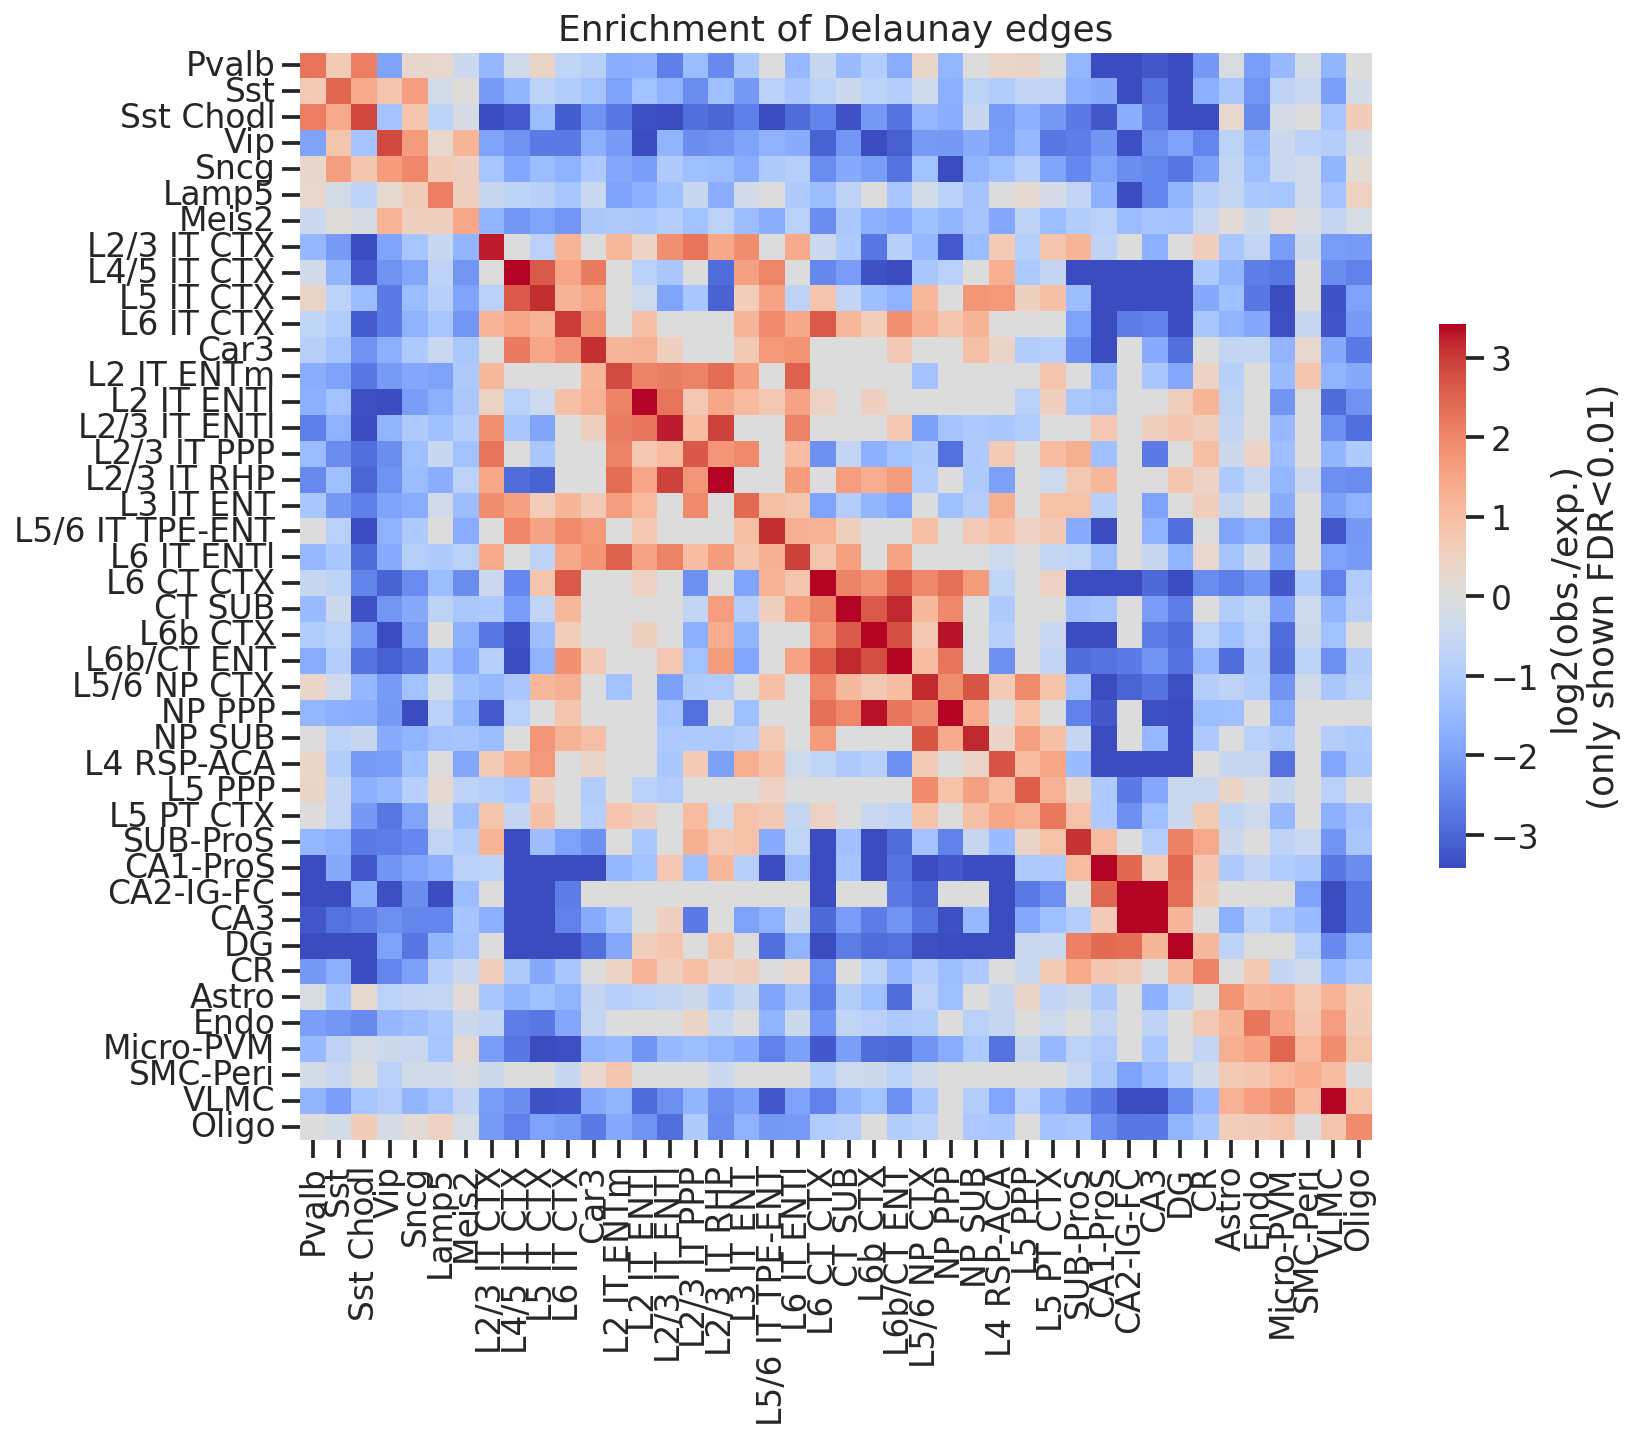

In [16]:
val = np.log2(enr)
val[qvals > alpha] = 0 # insignfiicant

fig, ax = plt.subplots(figsize=(12,10))
vmax = np.percentile(val, 95)
vmin = np.percentile(val, 5)
vlim = max(vmax, -vmin)
sns.heatmap(val, 
            xticklabels=True,
            yticklabels=True,
            cmap='coolwarm', 
            vmax=vlim,
            vmin=-vlim,
            center=0,
            ax=ax,
            cbar_kws=dict(shrink=0.5, label='log2(obs./exp.)\n(only shown FDR<0.01)')
           )
ax.set_title('Enrichment of Delaunay edges')
plt.show()

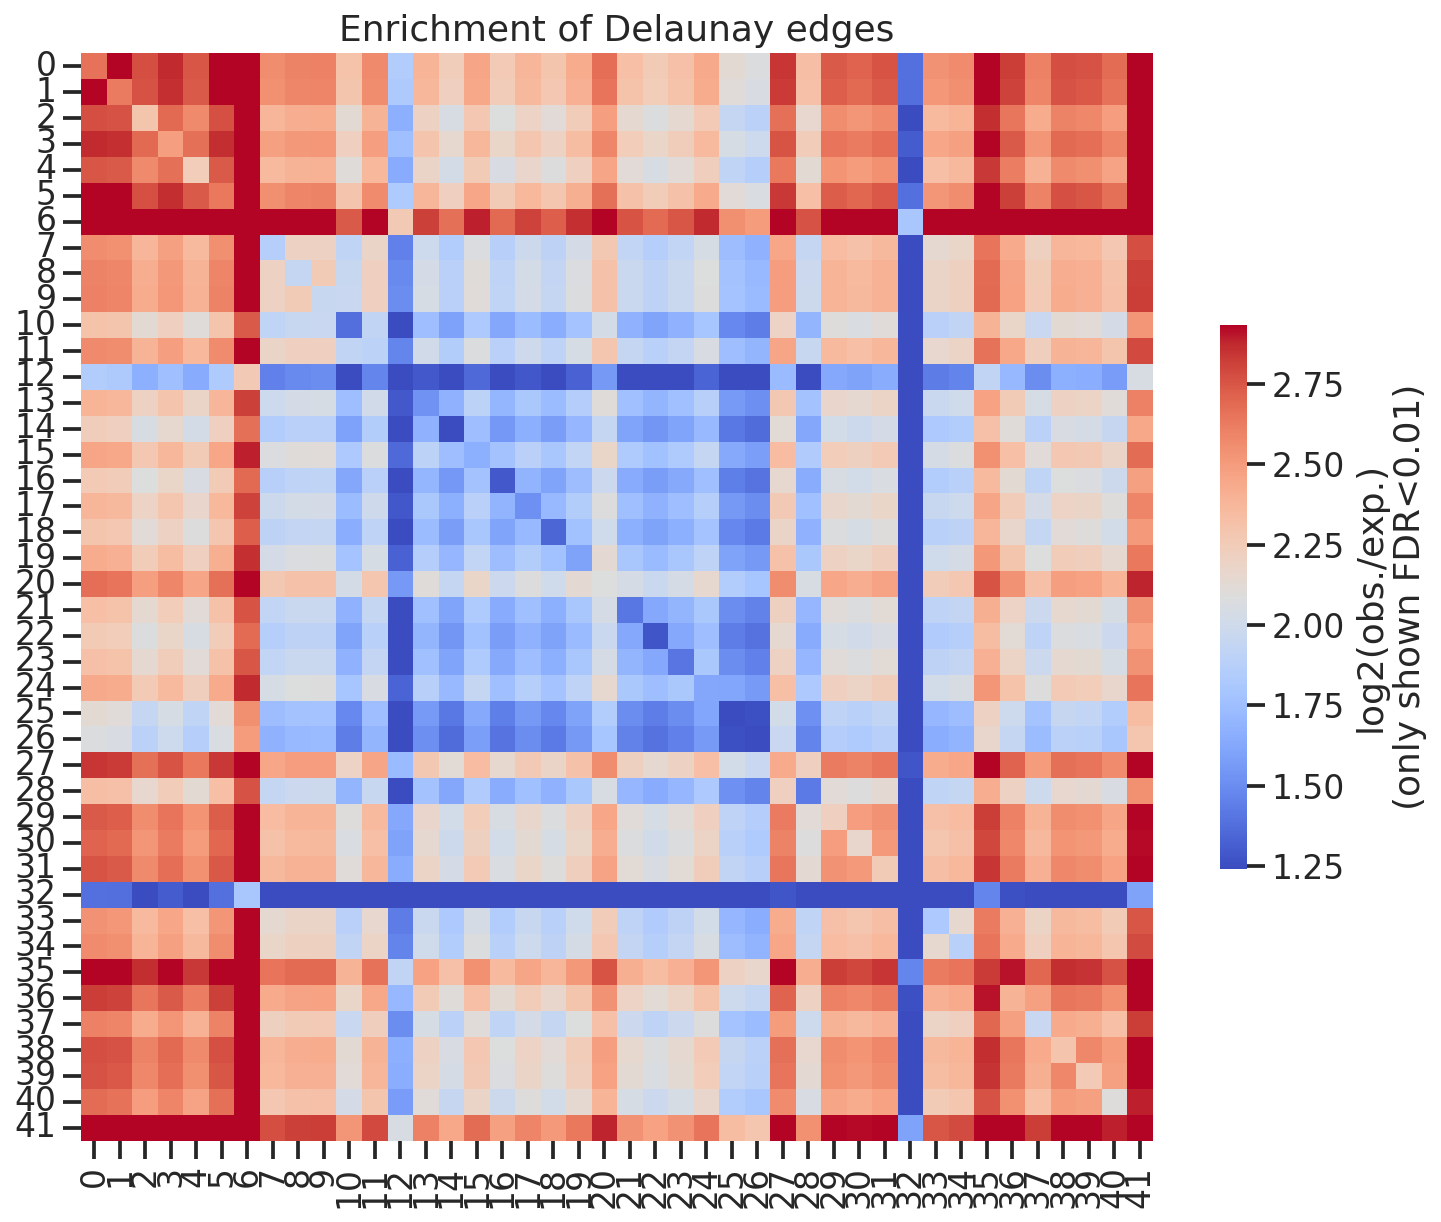

In [17]:
exp = np.mean(countmats[:,:,1:], axis=2)
val = np.log10(exp+1)

fig, ax = plt.subplots(figsize=(12,10))
vmax = np.percentile(val, 95)
vmin = np.percentile(val, 5)
# vlim = max(vmax, -vmin)
sns.heatmap(val, 
            xticklabels=True,
            yticklabels=True,
            cmap='coolwarm', 
            vmax=vmax,
            vmin=vmin,
            ax=ax,
            cbar_kws=dict(shrink=0.5, label='log2(obs./exp.)\n(only shown FDR<0.01)')
           )
ax.set_title('Enrichment of Delaunay edges')
plt.show()

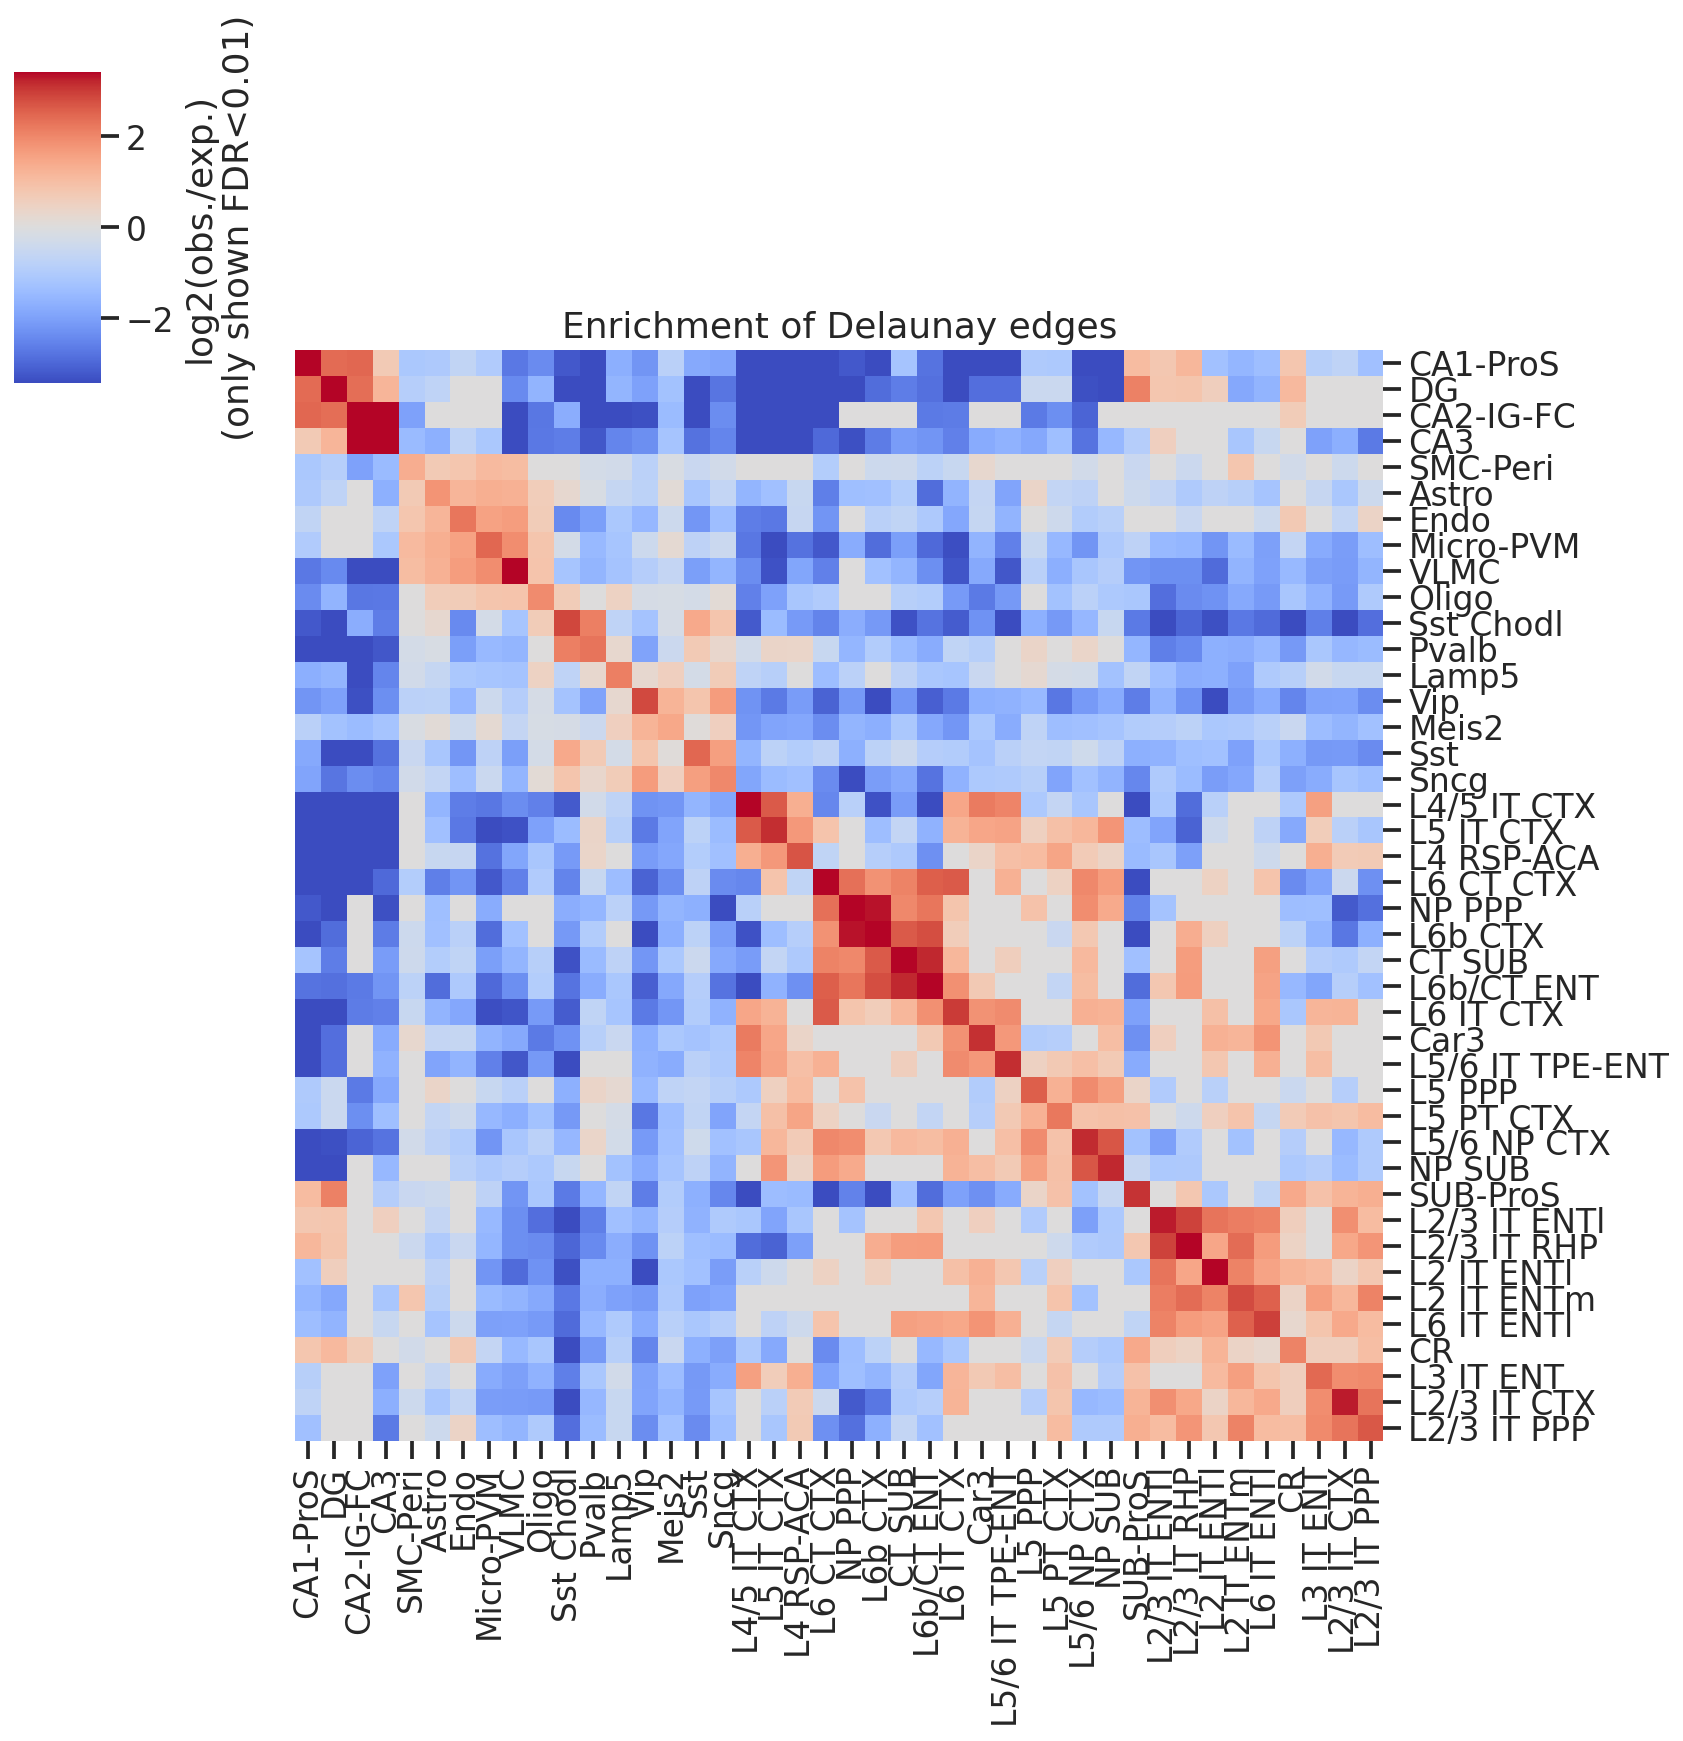

In [18]:
val = np.log2(enr)
val[qvals > alpha] = 0 # insignfiicant

vmax = np.percentile(val, 95)
vmin = np.percentile(val, 5)
vlim = max(vmax, -vmin)
g = sns.clustermap(val, 
            xticklabels=True,
            yticklabels=True,
            cmap='coolwarm', 
            vmax=vlim,
            vmin=-vlim,
            # ax=ax,
            cbar_kws=dict(shrink=0.5, label='log2(obs./exp.)\n(only shown FDR<0.01)'),
            figsize=(12,12),
           )

g.fig.axes[0].set_visible(False)
g.fig.axes[1].set_visible(False)
g.fig.axes[2].set_title('Enrichment of Delaunay edges')
plt.show()